In [1]:
# conda install -c conda-forge pyldavis

In [2]:
# in terminal
# python -m spacy download en_core_web_sm

In [3]:
# !conda install gensim -y

In [4]:
import spacy
import pickle
from emoji import UNICODE_EMOJI
import pyLDAvis

In [5]:
df = pickle.load(open("Data/clean_df.pickle","rb"))
spaced_notes = pickle.load(open("Data/spaced_notes.pickle","rb"))
demoji_notes = pickle.load(open("Data/demoji_notes.pickle","rb"))
defined_notes = pickle.load(open("Data/defined_notes.pickle","rb"))

Using a smaller set of notes to practice preprocessing

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
from sklearn.feature_extraction.text import TfidfVectorizer


In [7]:
import matplotlib.pyplot as plt

In [8]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join(feature_names[i] + ' ' + f'{topic[i]:9.2f}'
                        for i in topic.argsort()[:-no_top_words - 1:-1]))

# Topic Modeling

## defined_notes
### generate document-term matrix

https://stackoverflow.com/questions/57333183/sk-learn-countvectorizer-keeping-emojis-as-words

from sklearn.feature_extraction.text import TfidfVectorizer
s= ['👋 Welcome', '👋 Welcome']

v = TfidfVectorizer(token_pattern=r'[^\s]+')
v.fit(s)
v.get_feature_names()

['welcome', '👋']


In [9]:
vectorizer = CountVectorizer(token_pattern=r'[^\s]+',stop_words='english',min_df=200)
dtm = vectorizer.fit_transform(defined_notes)
dtm.shape

(286464, 756)

### LSA

In [10]:
# We have to convert `.toarray()` because the vectorizer returns a sparse matrix.
# For a big corpus, we would skip the dataframe and keep the output sparse.
dtm_lsa = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names())

In [11]:
dtm_lsa.columns

Index(['3', 'admission', 'airbnb', 'airplane', 'alien', 'amazon', 'american',
       'apple', 'april', 'arrow',
       ...
       '🥟', '🥤', '🥦', '🥩', '🥪', '🥯', '🥰', '🥳', '🦄', '🧀'],
      dtype='object', length=756)

In [12]:
# # Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)

lsa = TruncatedSVD(150)
doc_topic = lsa.fit(dtm[:100000])


In [13]:
sum(lsa.explained_variance_ratio_[0:150])

0.8274167096138046

In [36]:
with open('Models/lsa_defined_100k.pickle', 'wb') as f:
    pickle.dump(doc_topic, f)

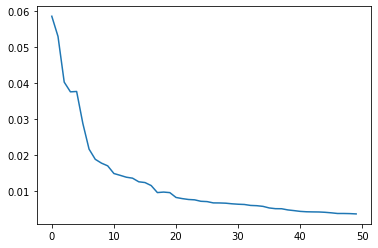

In [14]:
plt.plot(lsa.explained_variance_ratio_[0:50])

In [15]:
display_topics(lsa, vectorizer.get_feature_names(), 3)


Topic  0
skin      0.49, tone      0.49, light      0.29

Topic  1
hot      0.49, beverage      0.48, ☕      0.48

Topic  2
symbol      0.47, letter      0.47, regional      0.47

Topic  3
face      0.75, pizza      0.35, 🍕      0.34

Topic  4
pizza      0.63, 🍕      0.60, beverage      0.04

Topic  5
money      0.57, wings      0.48, 💸      0.48

Topic  6
cooking      0.33, 🍳      0.32, man      0.32

Topic  7
heart      0.65, red      0.47, ❤      0.45

Topic  8
football      0.61, american      0.56, 🏈      0.56

Topic  9
hamburger      0.70, 🍔      0.70, beer      0.07

Topic  10
party      0.49, 🎉      0.46, popper      0.46

Topic  11
taco      0.54, 🌮      0.52, burrito      0.33

Topic  12
sign      0.37, ‍      0.32, person      0.31

Topic  13
party      0.25, 🎉      0.23, popper      0.23

Topic  14
sushi      0.71, 🍣      0.70, rice      0.03

Topic  15
burrito      0.60, 🌯      0.59, beer      0.06

Topic  16
sweat      0.36, 💦      0.36, droplets      0.36

Topic  17
foo

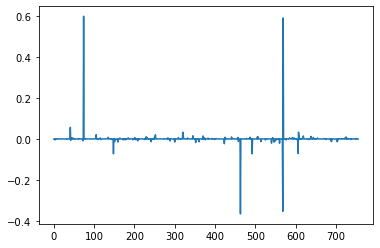

In [16]:
plt.plot(lsa.components_[15])

### NMF

In [17]:
nmf_model = NMF(20)
nmf_doc_topic = nmf_model.fit_transform(dtm[:100000])

In [37]:
with open('Models/nmf_defined_100k.pickle', 'wb') as f:
    pickle.dump(nmf_doc_topic, f)

In [18]:
display_topics(nmf_model, vectorizer.get_feature_names(), 3)


Topic  0
skin      7.16, tone      7.16, light      6.02

Topic  1
hot      5.89, beverage      5.76, ☕      5.75

Topic  2
symbol      5.54, letter      5.51, regional      5.51

Topic  3
face     11.20, smiling      3.20, eyes      1.51

Topic  4
pizza      7.32, 🍕      7.03, leg      0.03

Topic  5
money      6.17, wings      5.05, 💸      5.00

Topic  6
dark      3.50, man      3.45, skin      3.32

Topic  7
heart      6.18, red      4.38, ❤      4.21

Topic  8
football      5.44, american      5.00, 🏈      5.00

Topic  9
hamburger      6.28, 🍔      6.28, fries      0.35

Topic  10
party      5.90, popper      5.56, 🎉      5.56

Topic  11
taco      6.70, 🌮      6.50, tropical      1.09

Topic  12
sign      5.05, ‍      4.41, person      4.28

Topic  13
beer      5.90, mug      3.24, 🍺      3.23

Topic  14
sushi      5.83, 🍣      5.71, rice      0.28

Topic  15
burrito      5.27, 🌯      5.20, utility      0.09

Topic  16
high      3.25, voltage      3.16, ⚡      3.16

Topic  17
food

## Gensim

In [19]:
from gensim import matutils, models
import scipy.sparse

/Users/allen/opt/anaconda3/envs/metis/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [20]:
tdm = dtm.transpose()

In [21]:
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [22]:
import gensim.corpora as corpora

In [23]:
id2word2 = corpora.Dictionary([[k for k,v in vectorizer.vocabulary_.items()]])

In [24]:
vectorizer.vocabulary_.items()

dict_items([('b', 17), ('food', 185), ('💇', 675), ('person', 352), ('getting', 203), ('haircut', 226), ('face', 164), ('horns', 248), ('🎳', 627), ('bowling', 64), ('🍵', 603), ('teacup', 469), ('handle', 230), ('good', 212), ('⛽', 553), ('fuel', 196), ('pump', 376), ('raised', 381), ('fist', 178), ('🏿', 645), ('dark', 135), ('skin', 425), ('tone', 487), ('💃', 671), ('woman', 528), ('dancing', 134), ('🌮', 568), ('taco', 463), ('🥑', 740), ('avocado', 14), ('know', 274), ('tickets', 481), ('🙏', 721), ('folded', 184), ('hands', 231), ('🏼', 642), ('medium', 309), ('light', 288), ('uber', 499), ('got', 214), ('right', 394), ('ya', 533), ('cash', 88), ('money', 315), ('🔥', 705), ('🍗', 585), ('poultry', 374), ('leg', 283), ('🐔', 646), ('chicken', 97), ('🎫', 625), ('ticket', 480), ('🍿', 612), ('popcorn', 369), ('airbnb', 2), ('🌶', 573), ('hot', 250), ('pepper', 351), ('car', 84), ('🏻', 641), ('💯', 693), ('points', 363), ('💦', 689), ('sweat', 458), ('droplets', 151), ('lunch', 296), ('\u200d', 54

In [25]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [26]:
from datetime import datetime

In [27]:
print(datetime.now().strftime("%H:%M:%S"))
lda = models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=20, passes=50, workers=8)
lda.print_topics()
print(datetime.now().strftime("%H:%M:%S"))

20:09:30
20:23:35


In [39]:
with open('Models/lda_defined_286k.pickle', 'wb') as f:
    pickle.dump(lda, f)

In [28]:
lda.print_topics()

[(0,
  '0.113*"thank" + 0.060*"uber" + 0.059*"dollar" + 0.054*"banknote" + 0.050*"💵" + 0.047*"christmas" + 0.042*"chicken" + 0.039*"tree" + 0.032*"rice" + 0.030*"🐔"'),
 (1,
  '0.095*"hot" + 0.067*"beverage" + 0.065*"☕" + 0.051*"baby" + 0.050*"knife" + 0.046*"fork" + 0.046*"🍴" + 0.035*"groceries" + 0.035*"bills" + 0.030*"bag"'),
 (2,
  '0.239*"heart" + 0.141*"red" + 0.123*"❤" + 0.071*"️" + 0.031*"bowl" + 0.024*"🍜" + 0.024*"steaming" + 0.020*"mouth" + 0.019*"suit" + 0.017*"blue"'),
 (3,
  '0.327*"face" + 0.109*"smiling" + 0.064*"eyes" + 0.035*"fuel" + 0.034*"pump" + 0.034*"⛽" + 0.017*"😊" + 0.016*"grinning" + 0.015*"cat" + 0.015*"musical"'),
 (4,
  '0.072*"car" + 0.057*"cooking" + 0.056*"🍳" + 0.050*"hearts" + 0.049*"good" + 0.049*"3" + 0.049*"🥰" + 0.045*"basketball" + 0.043*"🏀" + 0.042*"arrow"'),
 (5,
  '0.147*"taco" + 0.133*"🌮" + 0.110*"thanks" + 0.074*"bottle" + 0.072*"🔥" + 0.057*"cork" + 0.057*"popping" + 0.057*"🍾" + 0.023*"doughnut" + 0.023*"🍩"'),
 (6,
  '0.068*"hearts" + 0.066*"cooki

In [29]:
from gensim.models import CoherenceModel

In [30]:
lda.log_perplexity(corpus)

-5.005676299249983

In [31]:
coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -10.474913260542657


In [32]:
import pyLDAvis

In [33]:
import pyLDAvis.gensim

In [34]:
id2word

{17: 'b',
 185: 'food',
 675: '💇',
 352: 'person',
 203: 'getting',
 226: 'haircut',
 164: 'face',
 248: 'horns',
 627: '🎳',
 64: 'bowling',
 603: '🍵',
 469: 'teacup',
 230: 'handle',
 212: 'good',
 553: '⛽',
 196: 'fuel',
 376: 'pump',
 381: 'raised',
 178: 'fist',
 645: '🏿',
 135: 'dark',
 425: 'skin',
 487: 'tone',
 671: '💃',
 528: 'woman',
 134: 'dancing',
 568: '🌮',
 463: 'taco',
 740: '🥑',
 14: 'avocado',
 274: 'know',
 481: 'tickets',
 721: '🙏',
 184: 'folded',
 231: 'hands',
 642: '🏼',
 309: 'medium',
 288: 'light',
 499: 'uber',
 214: 'got',
 394: 'right',
 533: 'ya',
 88: 'cash',
 315: 'money',
 705: '🔥',
 585: '🍗',
 374: 'poultry',
 283: 'leg',
 646: '🐔',
 97: 'chicken',
 625: '🎫',
 480: 'ticket',
 612: '🍿',
 369: 'popcorn',
 2: 'airbnb',
 573: '🌶',
 250: 'hot',
 351: 'pepper',
 84: 'car',
 641: '🏻',
 693: '💯',
 363: 'points',
 689: '💦',
 458: 'sweat',
 151: 'droplets',
 296: 'lunch',
 540: '\u200d',
 545: '♀',
 172: 'female',
 423: 'sign',
 605: '🍸',
 109: 'cocktail',
 208:

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus, dictionary=id2word2)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.052020 -0.201081       1        1  14.264187
3     -0.314033 -0.042591       2        1   7.507633
10     0.131235 -0.152563       3        1   6.572530
2     -0.000135 -0.144577       4        1   5.539789
1      0.095323 -0.244240       5        1   5.107083
9      0.091887 -0.030660       6        1   5.084039
14    -0.206679  0.010409       7        1   4.863949
8      0.042121  0.086974       8        1   4.719287
17     0.104874  0.078368       9        1   4.631519
18    -0.286136  0.013148      10        1   4.364753
0      0.039468  0.067771      11        1   4.305724
13     0.000365  0.120246      12        1   4.171197
15     0.046219 -0.104360      13        1   4.023326
16    -0.182418  0.020988      14        1   3.993521
19     0.037636 -0.062210      15        1   3.874284
6      0.091476  0.218852      16        1   3.599184
12     0.074584  0.039121      17        1   3.594886
5      0.050326  0.091156      18        1   3.470204
4      0.083497  0.187553      19        1   3.246427
7      0.048371  0.047694      20        1   3.066475, topic_info=       Term          Freq         Total Category  logprob  loglift
164    face  22346.000000  22346.000000  Default  30.0000  30.0000
235   heart   9966.000000   9966.000000  Default  29.0000  29.0000
185    food   7818.000000   7818.000000  Default  28.0000  28.0000
425    skin  11137.000000  11137.000000  Default  27.0000  27.0000
487    tone  11111.000000  11111.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
469  teacup    303.708069    304.630737  Topic20  -4.2663   3.4816
603       🍵    303.708069    304.630737  Topic20  -4.2663   3.4816
584       🍖    299.363617    300.286285  Topic20  -4.2807   3.4816
373  potato    298.748016    299.670685  Topic20  -4.2828   3.4816
102   class    288.986816    289.909485  Topic20  -4.3160   3.4815

[715 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0        19  0.998947          3
1         6  0.999381  admission
2        16  0.996111     airbnb
3         5  0.999177   airplane
5        16  0.996853     amazon
...     ...       ...        ...
750      14  0.999187          🥪
752      19  0.998947          🥰
753      14  0.998661          🥳
754       4  0.996317          🦄
755      13  0.999118          🧀

[723 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 4, 11, 3, 2, 10, 15, 9, 18, 19, 1, 14, 16, 17, 20, 7, 13, 6, 5, 8])

In [40]:
with open('Models/ldavis_defined_286k.pickle', 'wb') as f:
    pickle.dump(LDAvis_prepared, f)